In [3]:
import hestonpy
from hestonpy.models.heston import Heston, delta_vega_hedging
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Parameters for the Heston model
S0 = 100.0  # Initial spot price
V0 = 0.06  # Initial volatility
r = 0.03  # Risk-free interest rate
kappa = 1.0  # Mean reversion rate
theta = 0.06  # Long-term volatility
drift_emm = 0.01  # Drift term
sigma = 0.3  # Volatility of volatility
rho = -0.5  # Correlation between asset and volatility
T = 1.0  # Time to maturity in years
K = 100.0  # Strike price

K_hedging = 0.9 * K

heston = Heston(S0, V0, r, kappa, theta, drift_emm, sigma, rho, T, K)
heston_hedging = Heston(S0, V0, r, kappa, theta, drift_emm, sigma, rho, T, K_hedging)

nPaths = 2
nHedges = 252

portfolio, S, V, C = delta_vega_hedging(heston, heston_hedging, nHedges, nPaths)

Computing option prices ...
(2, 253)
Computing vegas ...
Computing deltas ...


100%|██████████| 251/251 [00:00<00:00, 86612.12it/s]


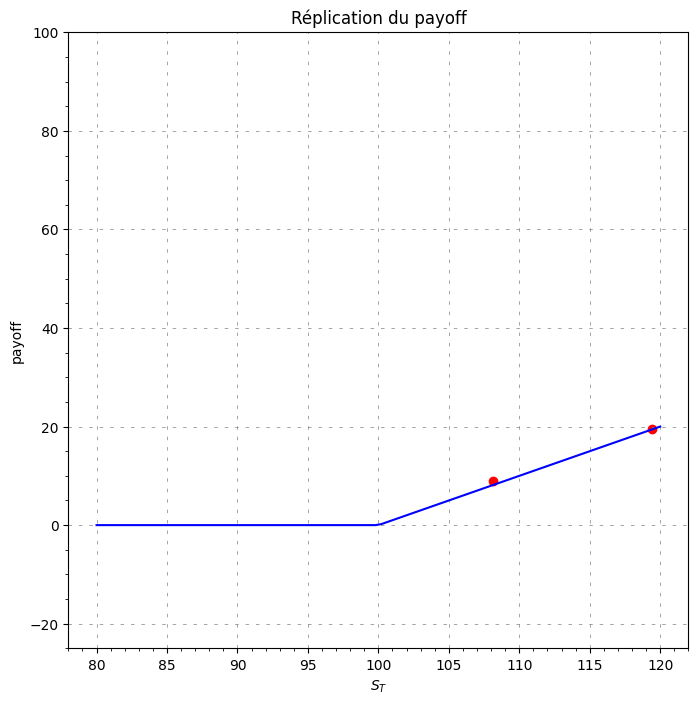

In [5]:
ST = S[:, -1]
VT = portfolio[:, -1]

plt.figure(figsize=(8, 8))

x = np.linspace(min(80,min(ST)), max(120,max(ST)), 100)
payoff = np.maximum(0, x - K)
plt.plot(x, payoff, color="blue")
plt.scatter(ST, VT, color="red")

plt.grid(linestyle="--", dashes=(5, 10), color="gray", linewidth=0.5)
plt.minorticks_on()
plt.xlabel(r"$S_T$")
plt.ylabel("payoff")
plt.ylim((-25,100))
plt.title("Réplication du payoff")

plt.show()

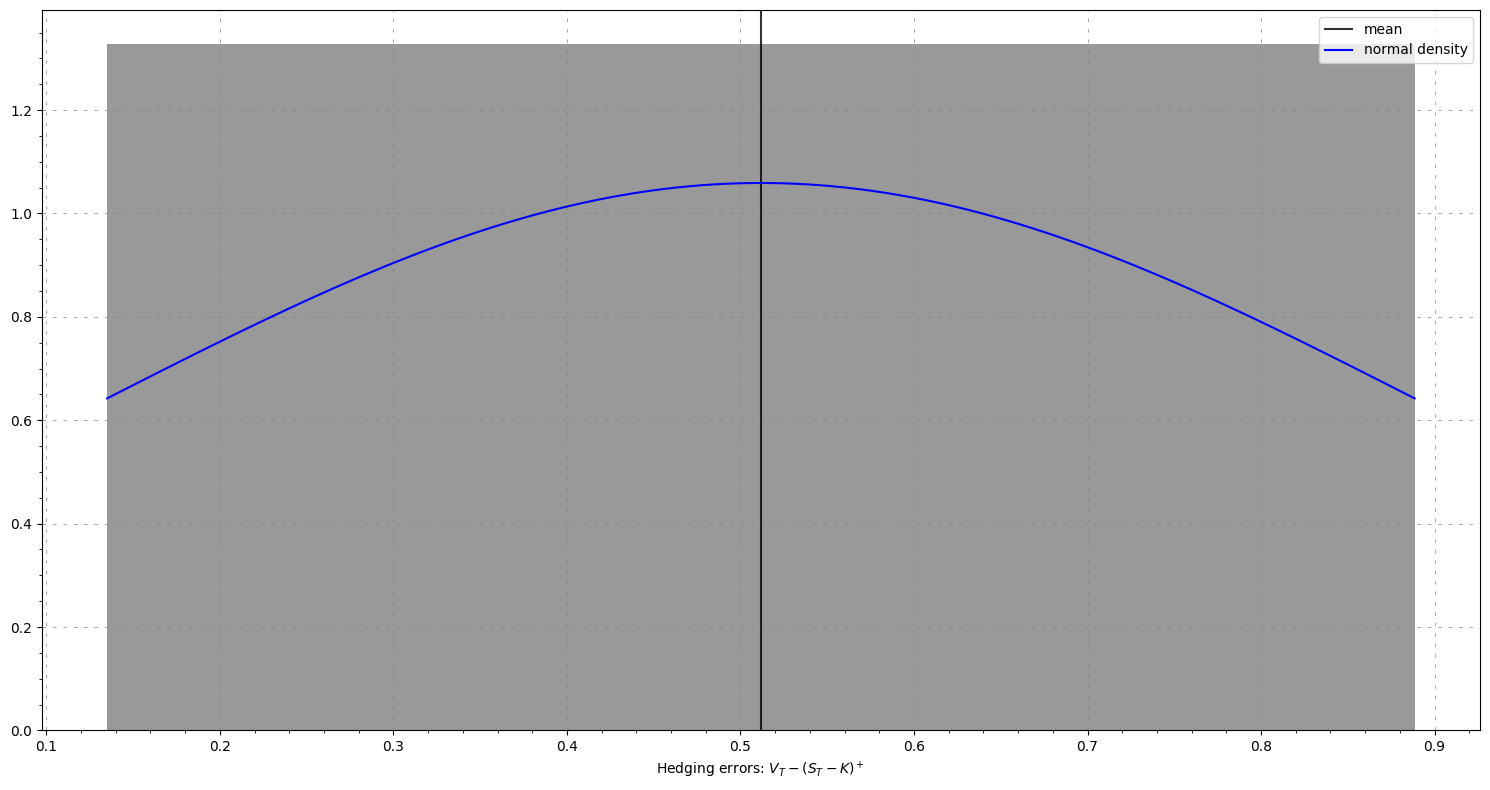

In [6]:
ST = S[:, -1]
VT = portfolio[:, -1]

from scipy.stats import norm

cash_flows = np.maximum(0, ST - K)
hedging_errors = VT - cash_flows
hedging_errors = hedging_errors[np.abs(hedging_errors) < 5]

plt.figure(figsize=(15, 8))
plt.hist(hedging_errors, bins="fd", density=True, color="gray", alpha=0.8)
plt.axvline(np.mean(hedging_errors), color="black", label="mean", alpha=0.8)

x = np.linspace(start=min(hedging_errors), stop=max(hedging_errors), num=100)
plt.plot(
    x,
    norm.pdf(x, loc=np.mean(hedging_errors), scale=np.std(hedging_errors)),
    label="normal density",
    color="blue",
)
plt.xlabel(r"Hedging errors: $V_T - (S_T - K)^+$")
plt.grid(linestyle="--", dashes=(5, 10), color="gray", linewidth=0.5)
plt.minorticks_on()
plt.legend()
plt.tight_layout()
plt.show()

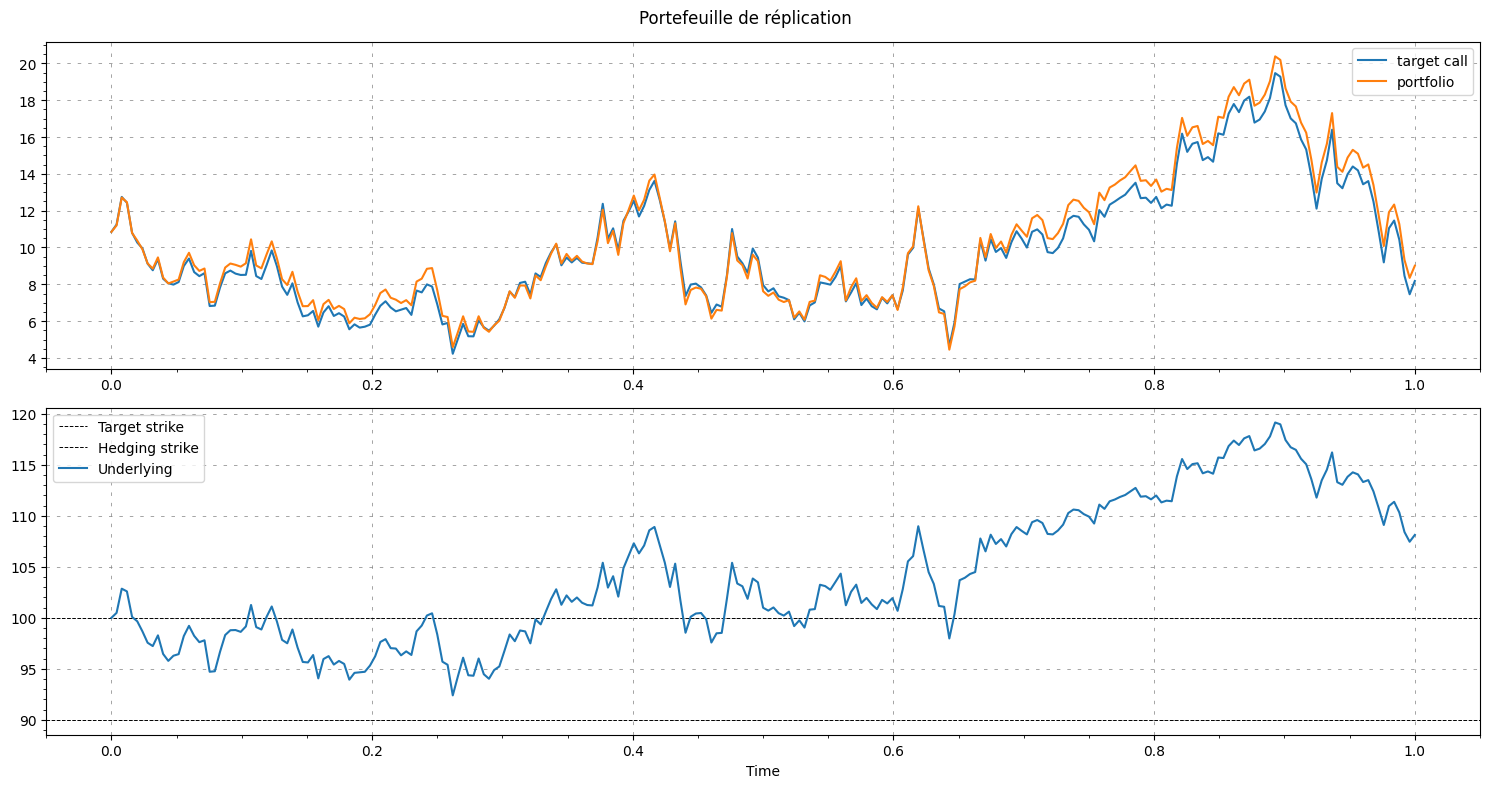

In [7]:
time = np.linspace(start=0, stop=heston.T, num=nHedges + 1)

path = 0

fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 8))

plt.suptitle("Portefeuille de réplication")

ax1.plot(time, C[path, :], label="target call")
ax1.plot(time, portfolio[path, :], label="portfolio")
ax1.grid(linestyle="--", dashes=(5, 10), color="gray", linewidth=0.5)
ax1.minorticks_on()
ax1.legend()

ax2.axhline(y=K, label="Target strike", linestyle="dashed", color='black', linewidth=0.7)
ax2.axhline(y=K_hedging, label="Hedging strike", linestyle="dashed", color='black', linewidth=0.7)
ax2.plot(time, S[path, :], label="Underlying")
ax2.grid(linestyle="--", dashes=(5, 10), color="gray", linewidth=0.5)
ax2.minorticks_on()
ax2.set_xlabel("Time")
ax2.legend()

plt.tight_layout()
plt.show()

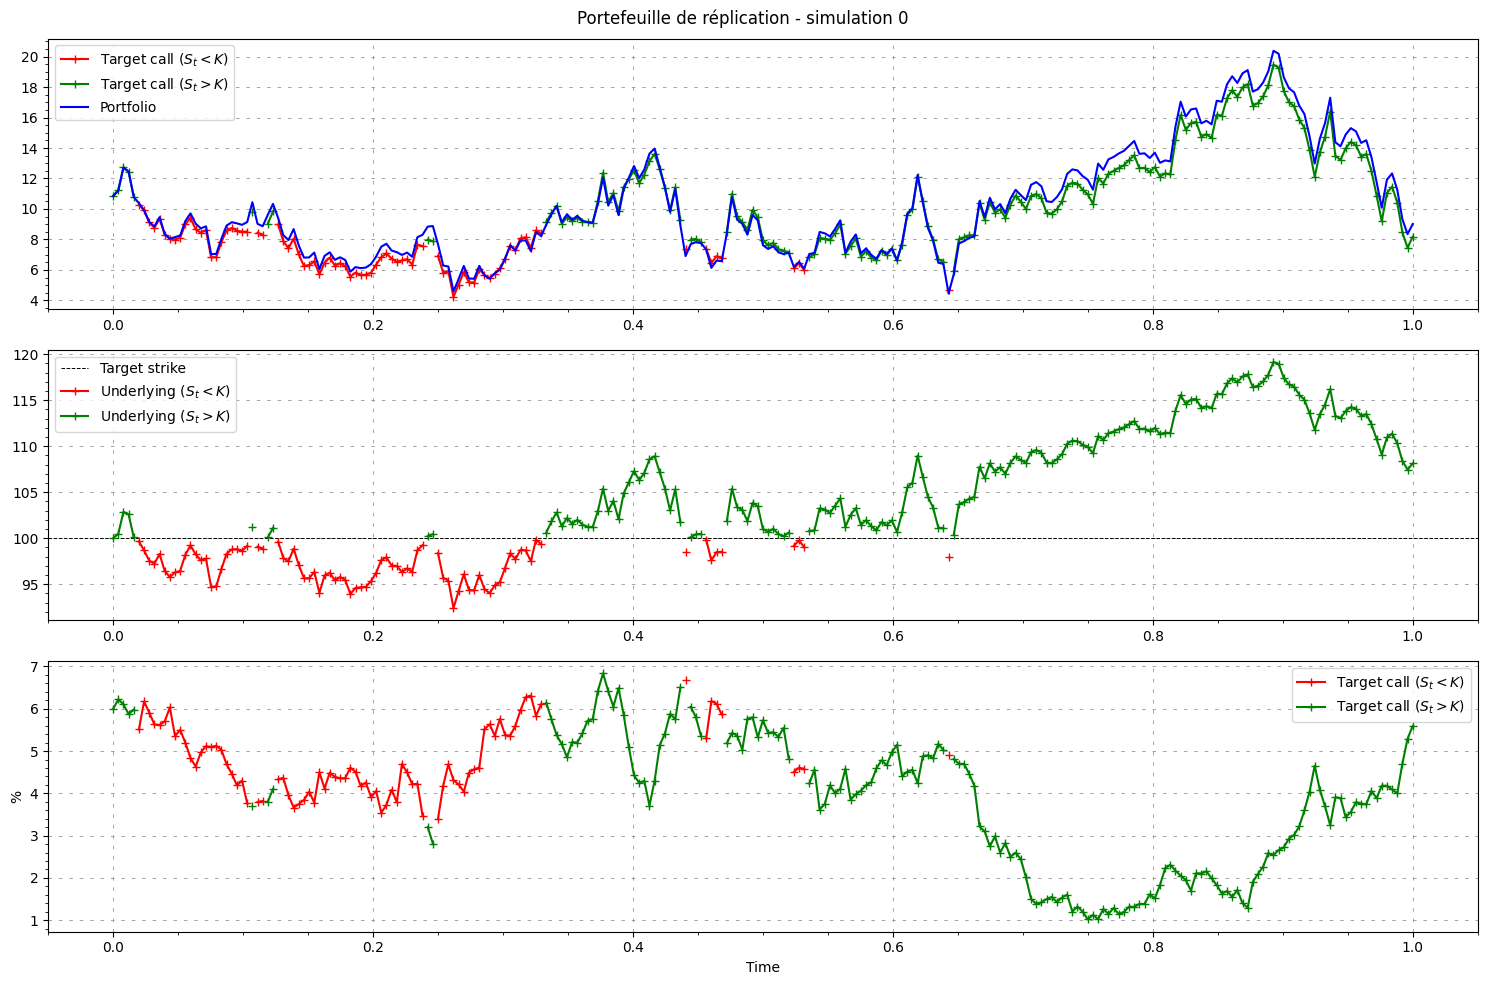

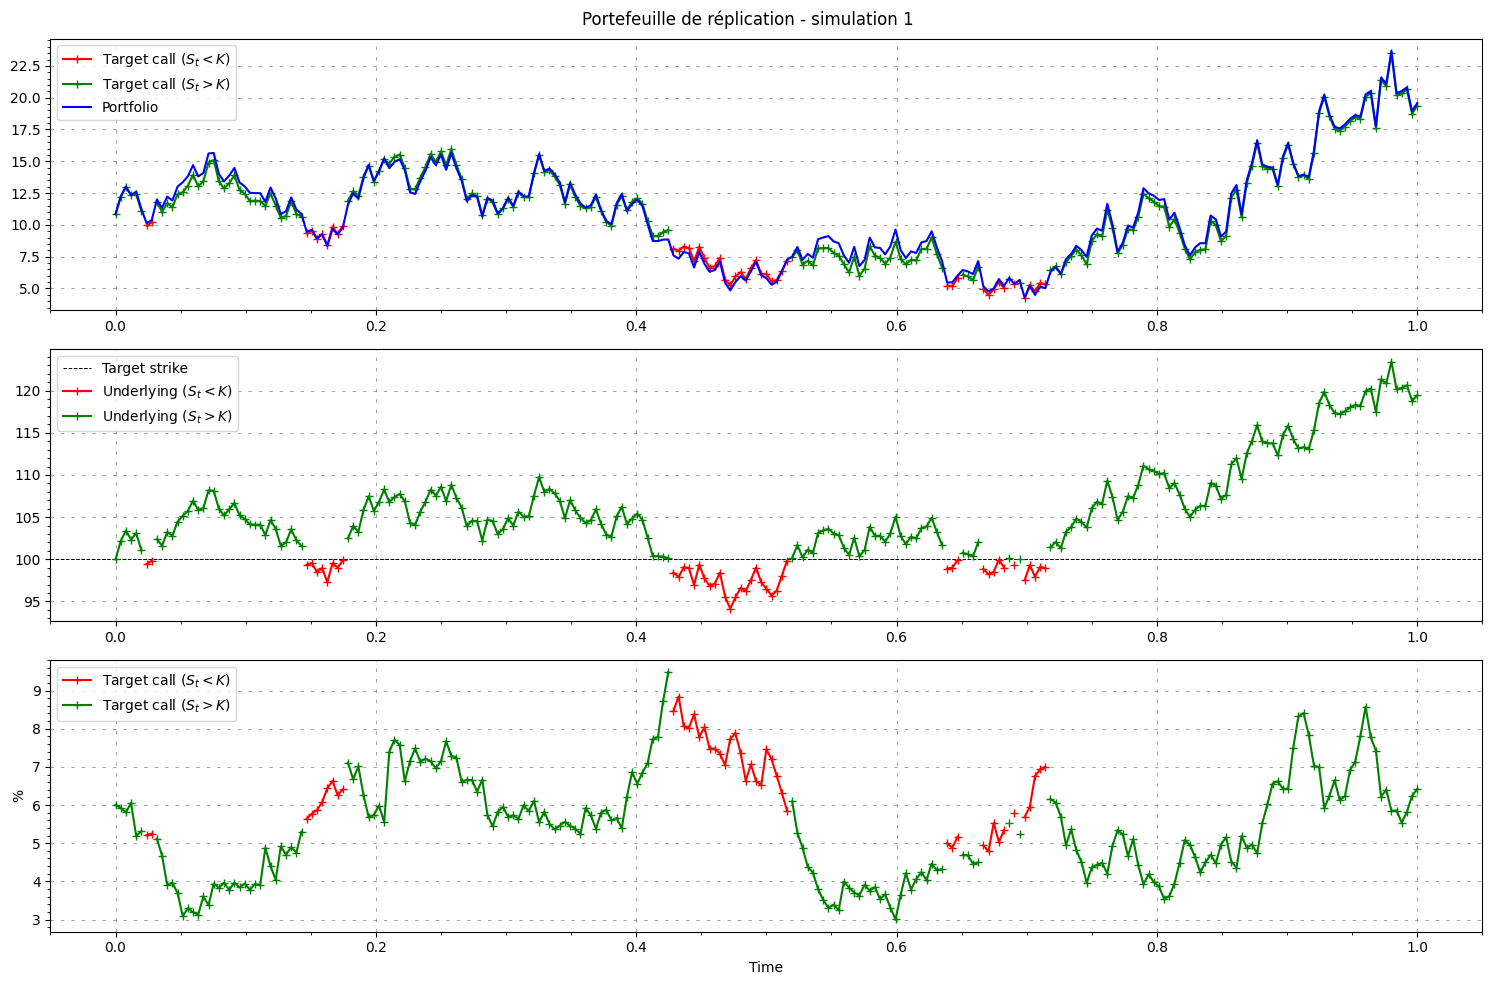

In [8]:
time = np.linspace(start=0, stop=heston.T, num=nHedges + 1)

paths = range(nPaths)

for path in paths:

    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15, 10))
    plt.suptitle(f"Portefeuille de réplication - simulation {path}")

    # Masquage des zones où S est en dessous du strike
    C_upper = np.ma.masked_where(S[path, :] < K, C[path, :])
    C_lower = np.ma.masked_where(S[path, :] >= K, C[path, :])

    St_upper = np.ma.masked_where(S[path, :] < K, S[path, :])
    St_lower = np.ma.masked_where(S[path, :] >= K, S[path, :])

    Vt_upper = np.ma.masked_where(S[path, :] < K, V[path, :])
    Vt_lower = np.ma.masked_where(S[path, :] >= K, V[path, :])

    # Tracé avec des styles différents
    ax1.plot(time, C_lower, label=r"Target call ($S_t < K$)", color='red', marker='+')
    ax1.plot(time, C_upper, label=r"Target call ($S_t > K$)", color='green', marker='+')
    ax1.plot(time, portfolio[path, :], label="Portfolio", color='blue')
    ax1.grid(linestyle="--", dashes=(5, 10), color="gray", linewidth=0.5)
    ax1.minorticks_on()
    ax1.legend()

    # Tracé du sous-jacent et des strikes
    ax2.axhline(y=K, label="Target strike", linestyle="dashed", color='black', linewidth=0.7)
    # ax2.plot(time, S[path, :], label="Underlying")
    ax2.plot(time, St_lower, label=r"Underlying ($S_t < K$)", color='red', marker='+')
    ax2.plot(time, St_upper, label=r"Underlying ($S_t > K$)", color='green', marker='+')
    ax2.grid(linestyle="--", dashes=(5, 10), color="gray", linewidth=0.5)
    ax2.minorticks_on()
    ax2.legend()

    # Tracé du sous-jacent et des strikes
    ax3.plot(time, Vt_lower*100, label=r"Target call ($S_t < K$)", color='red', marker='+')
    ax3.plot(time, Vt_upper*100, label=r"Target call ($S_t > K$)", color='green', marker='+')
    ax3.grid(linestyle="--", dashes=(5, 10), color="gray", linewidth=0.5)
    ax3.minorticks_on()
    ax3.set_xlabel("Time")
    ax3.set_ylabel("%")
    ax3.legend()

    plt.tight_layout()
    plt.show()